In [1]:
import sys
from outletsBiasRatings import outletsBiasRatingsAllSides,outletAbbreviationToFullName
from matplotlib.pyplot import *
import pandas as pd
import pickle
import time
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from transformers import pipeline, AutoTokenizer, AutoModelWithLMHead, BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import transformers

BATCH_SIZE=128
MAX_LENGTH=64

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Loading sentiment analysis pipeline from local store

In [2]:
# sentimentPipeline = pipeline(task='sentiment-analysis',model="./distilbert-base-uncased-finetuned-sst-2-english",device=0)#gpu device=0, #cpu device=-1,

sentimentPipeline = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english",device=0)#gpu device=0, #cpu device=-1

Some weights of RobertaModel were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def get_sentiment(sentimentPipeline,batch):
    labelsToNumbersDict={
                            'NEGATIVE':-1,'POSITIVE':1,
                        }
    try:
        predictions=sentimentPipeline(batch)
        numericPredictions=[]
        for prediction in predictions:
            numericPrediction=labelsToNumbersDict[prediction['label']]
            numericPredictions.append(numericPrediction)
        return numericPredictions
    except Exception as e:
#         raise
        print(e)  
        return None

In [4]:
#testing
batch=[
     "You are a piece of shit","Looking forward to meeting you","Canada: Buyout Challenged Over Racial Bias",
      "New H.I.V. Cases Rise in Young Gay Men",
      "Death Toll From Syria's Increasingly Grim War Passes 60,000",
    "Donald Trump’s re-election campaign poses the greatest threat to American democracy since World War II.",
    "Erin Wall, 44; Acclaimed Soprano in Mozart and Strauss",
    "Drug May Extend A.L.S. Patients’ Lives by Several Months, Study Finds",
    "Who Was ‘El Padrino,’ Godfather to Drug Cartel? Mexico’s Defense Chief, U.S. Says"
      ]
print(sentimentPipeline(batch))
print(get_sentiment(sentimentPipeline,batch))

for t in zip(batch,get_sentiment(sentimentPipeline,batch)):
    print(t[0],t[1])

[{'label': 'NEGATIVE', 'score': 0.9993973970413208}, {'label': 'POSITIVE', 'score': 0.9988988637924194}, {'label': 'NEGATIVE', 'score': 0.9986793994903564}, {'label': 'NEGATIVE', 'score': 0.982397735118866}, {'label': 'NEGATIVE', 'score': 0.9927184581756592}, {'label': 'NEGATIVE', 'score': 0.9969961643218994}, {'label': 'POSITIVE', 'score': 0.9983787536621094}, {'label': 'POSITIVE', 'score': 0.9964009523391724}, {'label': 'NEGATIVE', 'score': 0.991524875164032}]
[-1, 1, -1, -1, -1, -1, 1, 1, -1]
You are a piece of shit -1
Looking forward to meeting you 1
Canada: Buyout Challenged Over Racial Bias -1
New H.I.V. Cases Rise in Young Gay Men -1
Death Toll From Syria's Increasingly Grim War Passes 60,000 -1
Donald Trump’s re-election campaign poses the greatest threat to American democracy since World War II. -1
Erin Wall, 44; Acclaimed Soprano in Mozart and Strauss 1
Drug May Extend A.L.S. Patients’ Lives by Several Months, Study Finds 1
Who Was ‘El Padrino,’ Godfather to Drug Cartel? Mexi

In [5]:
df=pd.read_csv('./otagoSentiment.csv',names=["headline","sentiment"])
df.index = np.arange(1, len(df)+1)
df
df.style.set_properties(subset=['headline'], **{'width': '800px'})

,headline,sentiment
1,Epilogue: Unanswered Questions,-1
2,Rest in Preparation,1
3,NFL Linebacker Sam Acho: 'My Faith in Jesus is Part of Who I Am',1
4,Iraqis tout progress against ISIS as U.S. strikes continue,1
5,The Mad Search for Pro-Trump Columnists,-1
6,Pawlenty: GOP 'embracing' Dems' message by attacking Romney on corporate record,-1
7,Debunking The Myth That Pot Fries Your Brain,1
8,Premier banking 'is a waste of money' finds Which?,-1
9,The Battle of Midway at 75,-1
10,Actress in anti-Muslim film sues for its removal,-1


(array([638.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 482.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

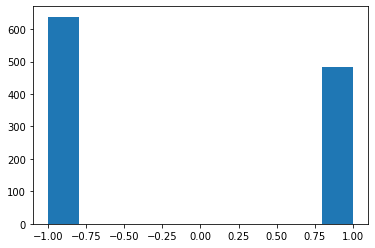

In [8]:
import matplotlib.pylab as plt
plt.hist(df.sentiment) #-1 negative, 1 positive

In [9]:
df=df.drop_duplicates(subset='headline')

In [10]:
sentimentLabelsAll=[]
headlinesAll=[]
urlsAll=[]
for rowIndex in range(0,len(df),BATCH_SIZE):
    print(rowIndex)
    try:

        dfBatch=df[rowIndex:rowIndex+BATCH_SIZE]
        headlines=list(dfBatch['headline'].values)
        urls=list(dfBatch.index)

        #Need to store headlines to URLs mapping since headlines longer than threshold will not be labelled
        headlinesToUrlsDict={}
        for headlineIndex, headline in enumerate(headlines):
            headlinesToUrlsDict[headline]=urls[headlineIndex]

        #making sure each headline is no longer than MAX_LENGTH tokens long
        headlinesBatch=[headline for headline in headlines if (type(headline)==str and len(headline.split())<=MAX_LENGTH)]

        sentimentLabels=get_sentiment(sentimentPipeline,headlinesBatch)
        sentimentLabelsAll += sentimentLabels

        headlinesAll += headlinesBatch

        #Only accumulate URLs of headlines that have been annotated because they fall below the length threshold
        urlsInBatch = [headlinesToUrlsDict[headline] for headline in headlinesBatch]
        urlsAll += urlsInBatch

    except Exception as e:
#                     raise
        print("Something happened in sentence labeling loop", e)
        continue

0
128
256
384
512
640
768
896
1024


## Estimate accuracy of predictions

In [11]:
modelPredictionsLabels=np.array(sentimentLabelsAll)
print(len(modelPredictionsLabels),modelPredictionsLabels[:20])

groundTruthLabels=df.sentiment.values
print(len(groundTruthLabels),groundTruthLabels[:20])

import sklearn
accuracy=sklearn.metrics.accuracy_score(modelPredictionsLabels,groundTruthLabels)
print(f"Accuracy: {accuracy}")

1120 [-1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1]
1120 [-1  1  1  1 -1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1]
Accuracy: 0.7482142857142857
